In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [2]:
# load Fama-French factor data
ff5_data = pd.read_csv('data/raw/ff5_data.csv', index_col=0)
ff5_data.index = pd.to_datetime(ff5_data.index, errors='coerce')
ff5_data = ff5_data[ff5_data.index.notna()]  

# load S&P 500 returns
gspc_returns = pd.read_csv('data/raw/gspc_monthly_returns.csv', index_col=0)
gspc_returns.index = pd.to_datetime(gspc_returns.index, errors='coerce')
gspc_returns = gspc_returns[gspc_returns.index.notna()]

sp500_returns = pd.read_csv('data/raw/market_data.csv', index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index, errors='coerce')
sp500_returns = sp500_returns[sp500_returns.index.notna()]

print("Data loaded successfully!")
print(f"FF5 data: {ff5_data.shape}")
print(f"GSPC returns: {gspc_returns.shape}")
print(f"SP500 returns: {sp500_returns.shape}")

Data loaded successfully!
FF5 data: (15646, 6)
GSPC returns: (250, 1)
SP500 returns: (250, 503)


#### Fama-French 5 Factors 

**Mkt-RF (Market Risk Premium)**  
Market return minus risk-free rate. Measures if stocks beat safe investments.

**SMB (Small Minus Big)**  
Small-cap vs large-cap performance. Captures size effect.

**HML (High Minus Low)**  
Value stocks vs growth stocks. The "value premium."

**RMW (Robust Minus Weak)**  
Profitable vs unprofitable companies. Quality factor.

**CMA (Conservative Minus Aggressive)**  
Conservative vs aggressive investors. Investment discipline factor.

**RF (Risk-Free Rate)**  
Return on safe investments (T-bills). Baseline return.


##### Interpreting Positive vs Negative Values

| Factor | Positive Means | Negative Means |
|--------|---------------|----------------|
| **Mkt-RF** | Stocks beat bonds | Bonds beat stocks |
| **SMB** | Small caps win | Large caps win |
| **HML** | Value stocks win | Growth stocks win |
| **RMW** | Profitable firms win | Unprofitable firms win |
| **CMA** | Conservative wins | Aggressive wins |
| **RF** | Higher safe returns | Lower safe returns |

#### data exploration

In [3]:
# limit data to understandable range
ff5_recent = ff5_data.loc['2005-01-01':]
print(f"Data range: {ff5_recent.index[0]} to {ff5_recent.index[-1]}")
print(f"Shape: {ff5_recent.shape}")
print("\nFirst 10 rows:")
print(ff5_recent.head(10))

Data range: 2005-01-03 00:00:00 to 2025-08-29 00:00:00
Shape: (5198, 6)

First 10 rows:
            Mkt-RF   SMB   HML   RMW   CMA    RF
Date                                            
2005-01-03   -0.97 -0.63 -0.05  0.35 -0.01  0.01
2005-01-04   -1.30 -0.51  0.44  0.83 -0.48  0.01
2005-01-05   -0.51 -1.14  0.02  0.04 -0.13  0.01
2005-01-06    0.34 -0.03  0.13  0.52 -0.12  0.01
2005-01-07   -0.22 -0.84 -0.10 -0.15 -0.02  0.01
2005-01-10    0.42  0.29  0.12  0.00 -0.23  0.01
2005-01-11   -0.68 -0.29  0.37  0.88 -0.17  0.01
2005-01-12    0.38 -0.09 -0.09 -0.22  0.12  0.01
2005-01-13   -0.77  0.24  0.39  0.05  0.01  0.01
2005-01-14    0.66  0.50  0.04 -0.19  0.15  0.01


In [4]:

# 3.2 Main characteristics of data
print("\n=== SUMMARY STATISTICS ===")
print(ff5_recent.describe())

print("\n=== DATA TYPES ===")
print(ff5_recent.dtypes)

print("\n=== MISSING VALUES ===")
missing = ff5_recent.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

# Drop rows with missing values
ff5_recent = ff5_recent.dropna()

# Convert index to datetime if not already
ff5_recent.index = pd.to_datetime(ff5_recent.index)

# Resample to monthly data to reduce points
ff5_monthly = ff5_recent.resample('M').last() 


=== SUMMARY STATISTICS ===
            Mkt-RF          SMB          HML          RMW          CMA  \
count  5198.000000  5198.000000  5198.000000  5198.000000  5198.000000   
mean      0.041404    -0.001812    -0.002607     0.014086     0.000323   
std       1.228130     0.639605     0.799425     0.456507     0.393704   
min     -12.010000    -4.580000    -5.030000    -2.710000    -2.920000   
25%      -0.430000    -0.370000    -0.340000    -0.230000    -0.200000   
50%       0.070000    -0.010000    -0.020000     0.010000    -0.010000   
75%       0.600000     0.350000     0.317500     0.250000     0.190000   
max      11.360000     5.710000     6.730000     4.250000     2.470000   

                RF  
count  5198.000000  
mean      0.006637  
std       0.008202  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.010000  
max       0.020000  

=== DATA TYPES ===
Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
RF    

In [5]:
ff5_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2005-01-31,0.97,0.85,0.14,-0.21,-0.11,0.01
2005-02-28,-0.61,0.23,0.05,0.41,0.16,0.01
2005-03-31,-0.01,0.07,0.64,0.03,0.26,0.01
2005-04-30,1.04,-0.41,-0.05,-0.16,-0.14,0.01
2005-05-31,-0.49,0.47,0.32,-0.12,0.14,0.01
...,...,...,...,...,...,...
2025-04-30,0.03,-0.86,-0.60,-0.02,0.08,0.02
2025-05-31,-0.02,-0.38,-0.21,0.12,-0.76,0.02
2025-06-30,0.49,-0.47,-0.12,-0.37,0.17,0.02


#### plot FF factors with historical context

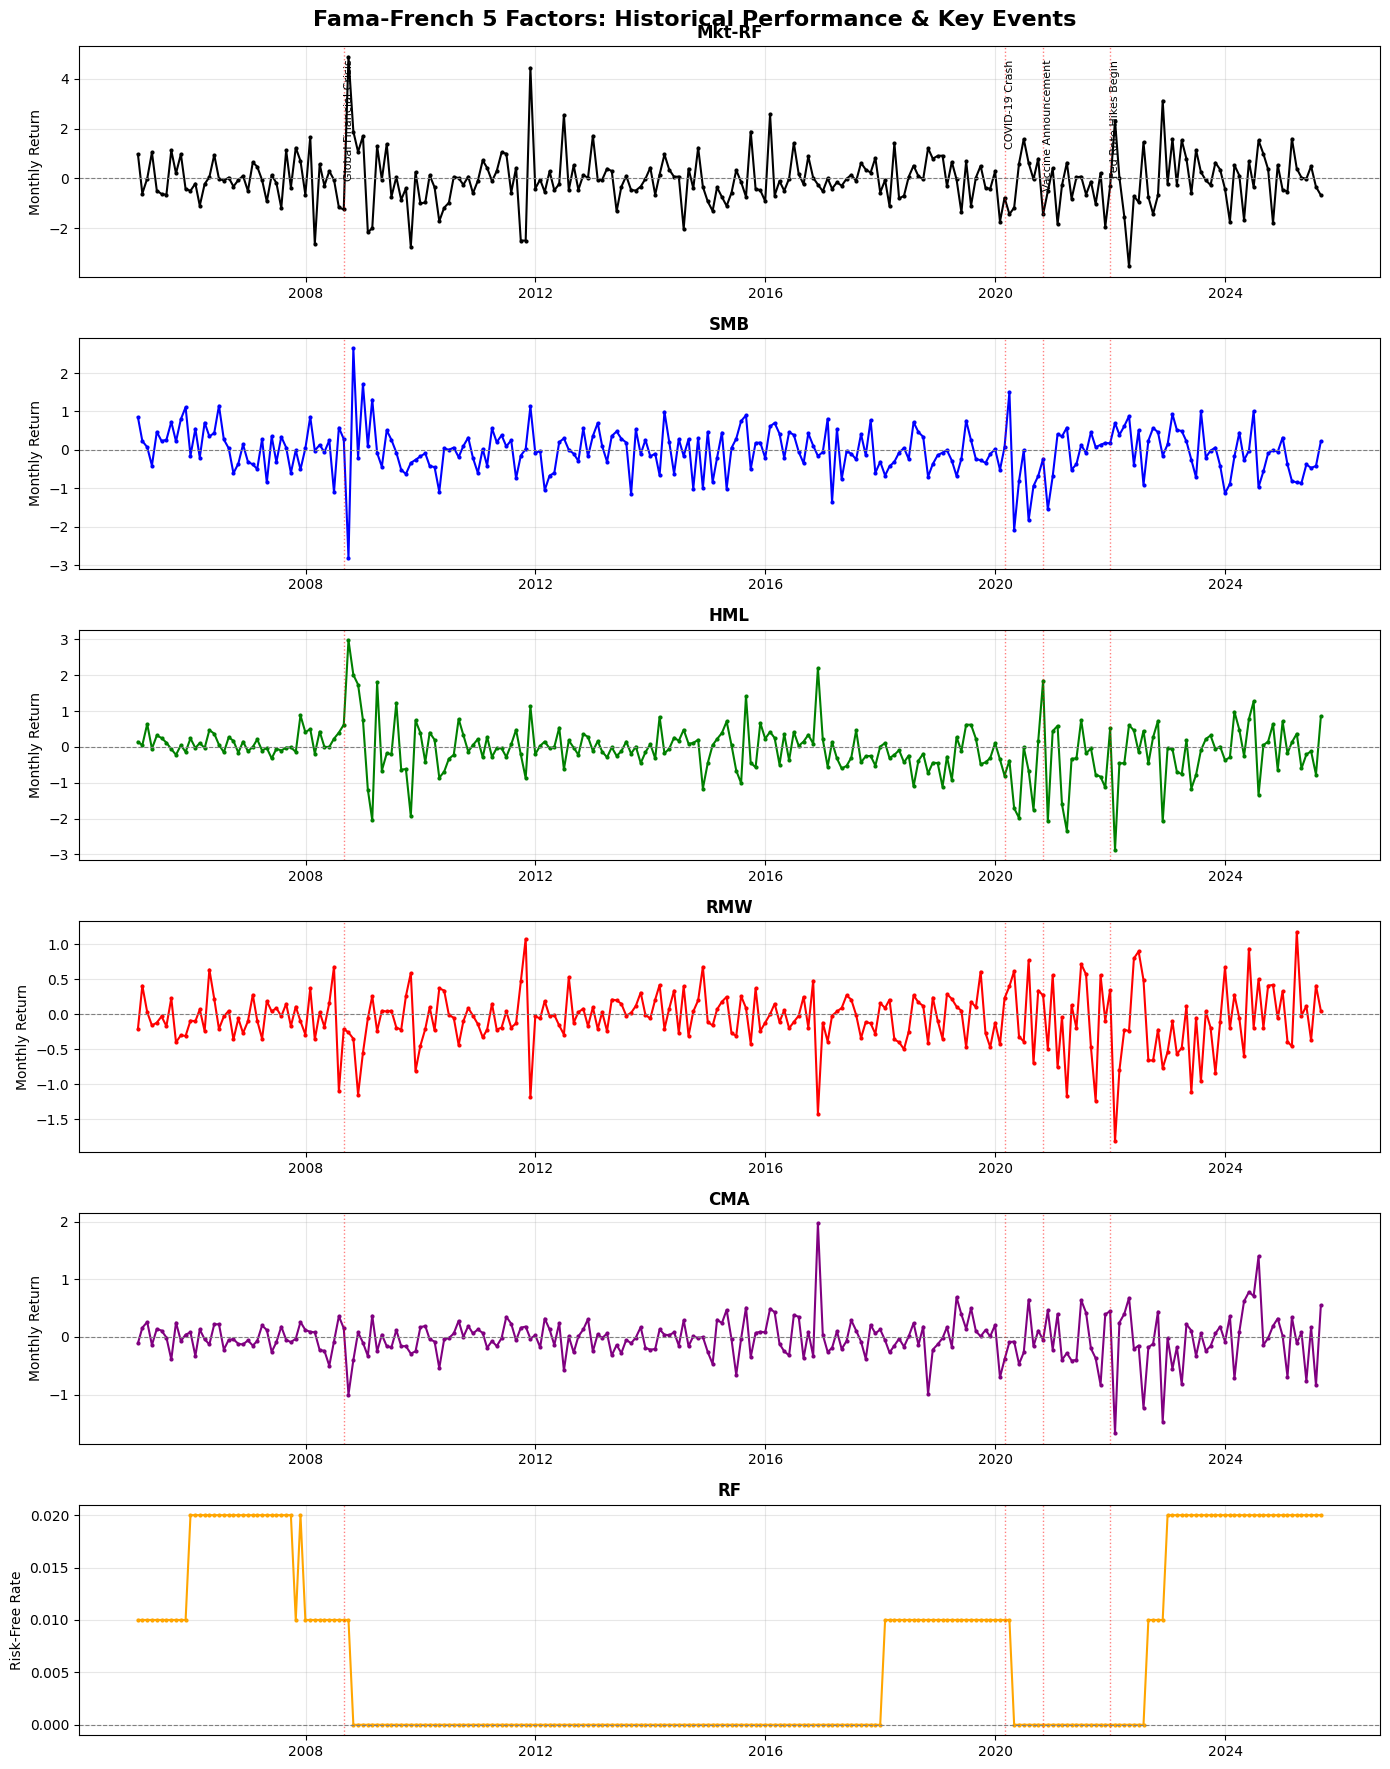

<Figure size 640x480 with 0 Axes>

Original data points: 5198
Monthly sampled points: 248


In [6]:
fig, axes = plt.subplots(6, 1, figsize=(14, 18))
fig.suptitle('Fama-French 5 Factors: Historical Performance & Key Events', 
             fontsize=16, fontweight='bold')

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['black', 'blue', 'green', 'red', 'purple', 'orange']

# Key historical events to annotate
events = {    
    '2008-09': 'Global Financial Crisis',
    '2020-03': 'COVID-19 Crash',
    '2020-11': 'Vaccine Announcement',
    '2022-01': 'Fed Rate Hikes Begin',    
}

for i, (factor, color) in enumerate(zip(factors, colors)):
    # Plot the time series
    axes[i].plot(ff5_monthly.index, ff5_monthly[factor], color=color, linewidth=1.5, marker='o', markersize=2)
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    
    # Better y-axis label based on what FF data actually is
    if factor == 'RF':
        axes[i].set_ylabel('Risk-Free Rate', fontsize=10)
    else:
        axes[i].set_ylabel('Monthly Return', fontsize=10)
    
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add event annotations
    for date, event in events.items():
        event_date = pd.to_datetime(date)
        if event_date >= ff5_monthly.index.min() and event_date <= ff5_monthly.index.max():
            axes[i].axvline(x=event_date, color='red', 
                          linestyle=':', alpha=0.5, linewidth=1)
            # Add text label only on first subplot
            if i == 0:
                axes[i].text(event_date, axes[i].get_ylim()[1]*0.9, event, 
                           rotation=90, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

print(f"Original data points: {len(ff5_recent)}")
print(f"Monthly sampled points: {len(ff5_monthly)}")



#### Statistical Method #1 – Distribution & Summary Statistics


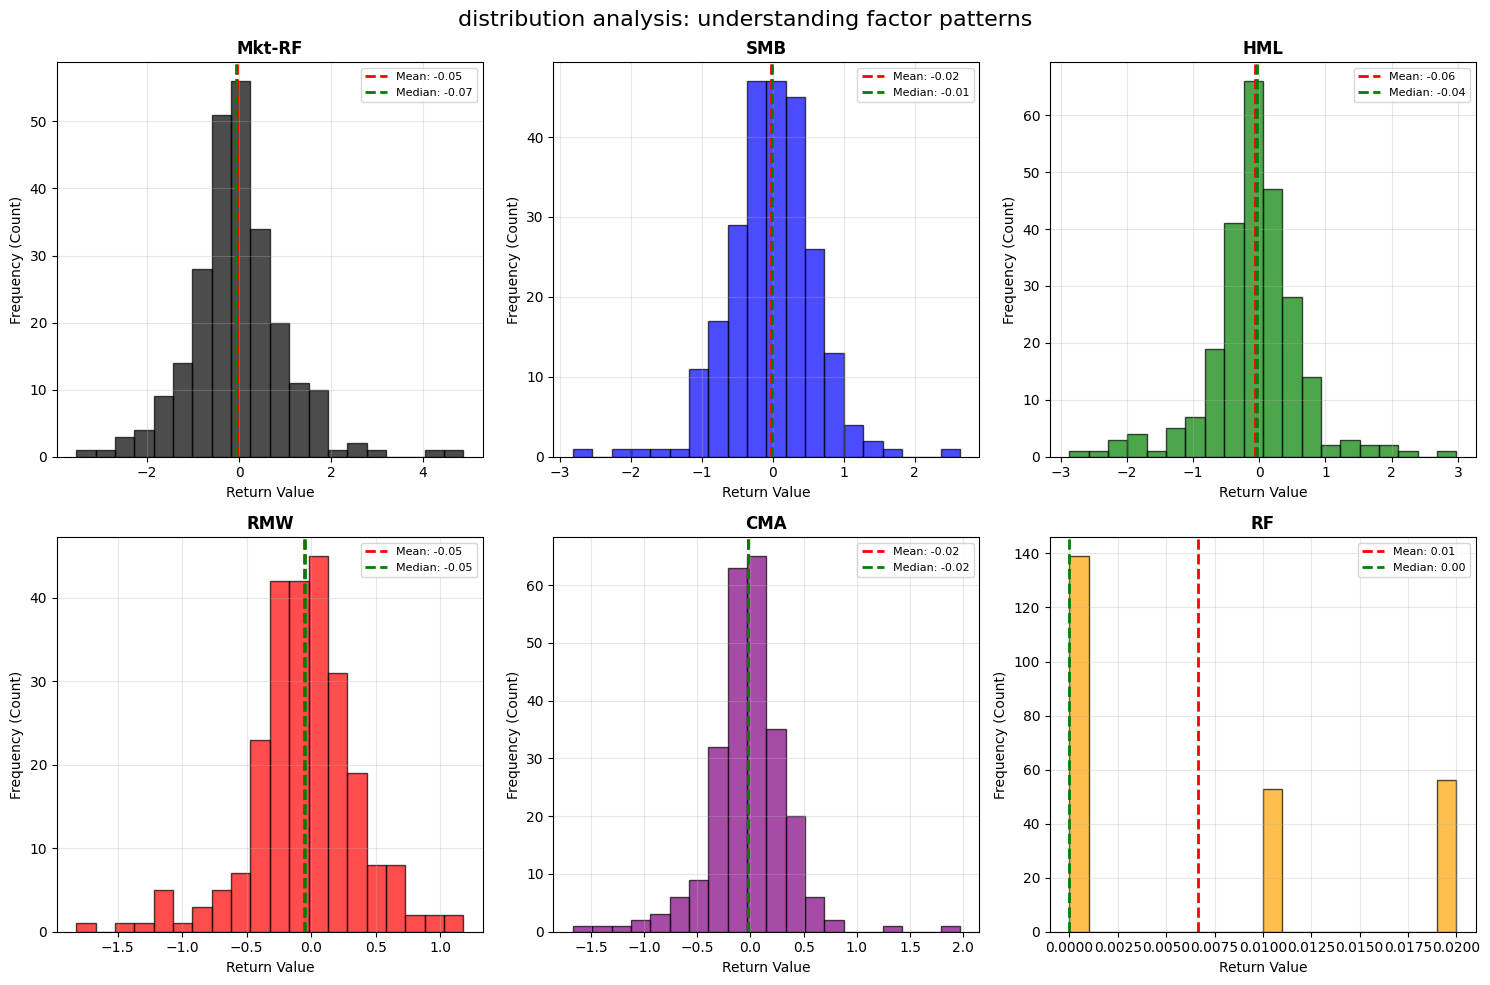

In [7]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('distribution analysis: understanding factor patterns', fontsize=16)

axes = axes.flatten()
for i, factor in enumerate(factors):
    # Simple histogram
    axes[i].hist(ff5_monthly[factor], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
    
    # Add mean line
    mean_val = ff5_monthly[factor].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    # Add median line
    median_val = ff5_monthly[factor].median()
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{factor}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Return Value', fontsize=10)
    axes[i].set_ylabel('Frequency (Count)', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# statistics
print("\n=== STATISTICS FOR EACH FACTOR ===\n")
for factor in factors:
    print(f"{factor}:")
    print(f"  Mean (Average):     {ff5_monthly[factor].mean():.4f}")
    print(f"  Median (Middle):    {ff5_monthly[factor].median():.4f}")
    print(f"  Std Dev (Spread):   {ff5_monthly[factor].std():.4f}")
    print()

# check for symmetry 
print("\n=== IS THE DATA BALANCED? ===\n")
for factor in factors:
    mean_val = ff5_monthly[factor].mean()
    median_val = ff5_monthly[factor].median()
    std_dev = ff5_monthly[factor].std()
    
    if abs(mean_val - median_val) < 0.1 * std_dev:
        balance = " Balanced (mean ≈ median)"
    elif mean_val > median_val:
        balance = " Right-skewed (more extreme positive values)"
    else:
        balance = " Left-skewed (more extreme negative values)"
    
    print(f"{factor}: {balance}")


=== STATISTICS FOR EACH FACTOR ===

Mkt-RF:
  Mean (Average):     -0.0452
  Median (Middle):    -0.0650
  Std Dev (Spread):   1.0405

SMB:
  Mean (Average):     -0.0217
  Median (Middle):    -0.0100
  Std Dev (Spread):   0.6105

HML:
  Mean (Average):     -0.0609
  Median (Middle):    -0.0350
  Std Dev (Spread):   0.7023

RMW:
  Mean (Average):     -0.0540
  Median (Middle):    -0.0500
  Std Dev (Spread):   0.4117

CMA:
  Mean (Average):     -0.0225
  Median (Middle):    -0.0200
  Std Dev (Spread):   0.3714

RF:
  Mean (Average):     0.0067
  Median (Middle):    0.0000
  Std Dev (Spread):   0.0082


=== IS THE DATA BALANCED? ===

Mkt-RF:  Balanced (mean ≈ median)
SMB:  Balanced (mean ≈ median)
HML:  Balanced (mean ≈ median)
RMW:  Balanced (mean ≈ median)
CMA:  Balanced (mean ≈ median)
RF:  Right-skewed (more extreme positive values)


In [9]:
ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].describe()


,Mkt-RF,SMB,HML,RMW,CMA,RF
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,-0.045242,-0.021694,-0.060887,-0.053992,-0.022540,0.006653
std,1.040452,0.610501,0.702300,0.411724,0.371444,0.008228
min,-3.540000,-2.820000,-2.870000,-1.820000,-1.670000,0.000000
25%,-0.570000,-0.362500,-0.335000,-0.240000,-0.182500,0.000000
50%,-0.065000,-0.010000,-0.035000,-0.050000,-0.020000,0.000000
75%,0.440000,0.342500,0.262500,0.182500,0.162500,0.010000
max,4.880000,2.640000,2.980000,1.180000,1.970000,0.020000


**Quantitative conclusion (Method #1):**

Using `ff5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].describe()`:

- The market factor **Mkt-RF** has an average of about **−0.045** with a standard deviation of about **1.040**. So typical monthly moves are roughly ±1.0 around a mean that is essentially zero.
- The size (**SMB**), value (**HML**), profitability (**RMW**), and investment (**CMA**) factors all have means between about **−0.061** and **−0.022**, with standard deviations between roughly **0.37** and **0.70**. They are centered very close to zero and are less volatile than the market factor.
- The risk-free rate **RF** is extremely small and stable, with a mean of about **0.007** and a standard deviation of about **0.008**.

Overall, this distribution analysis shows that **Mkt-RF is the main source of variation in the FF5 set**, while the other factors behave like smaller, near-zero tilts that matter more in specific market regimes than in the average month.



#### Statistical Method #2 – Outliers via Boxplots + IQR Rule


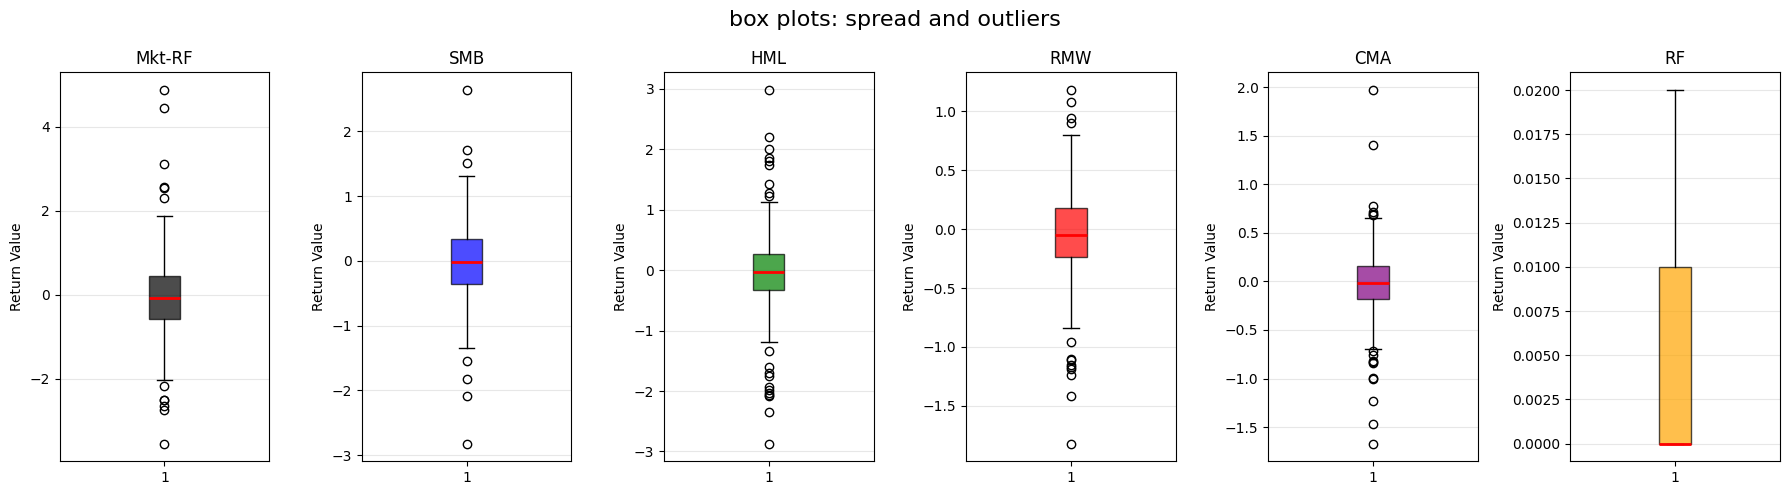

- Box: Middle 50% of data (25th to 75th percentile)
- Red line: Median (middle value)
- Whiskers: Typical range of data
- Dots: Outliers (unusual extreme values)


In [10]:

# box plots to see spread and outliers
fig, axes = plt.subplots(1, 6, figsize=(18, 5))
fig.suptitle('box plots: spread and outliers', fontsize=16)

for i, factor in enumerate(factors):
    axes[i].boxplot(ff5_monthly[factor], patch_artist=True,
                   boxprops=dict(facecolor=colors[i], alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
    axes[i].set_title(factor, fontsize=12)
    axes[i].set_ylabel('Return Value', fontsize=10)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("- Box: Middle 50% of data (25th to 75th percentile)")
print("- Red line: Median (middle value)")
print("- Whiskers: Typical range of data")
print("- Dots: Outliers (unusual extreme values)")

In [11]:
# Outlier detection using IQR rule
outlier_counts = {}

print("=== OUTLIER COUNTS USING IQR RULE ===")
for factor in factors:
    q1 = ff5_monthly[factor].quantile(0.25)
    q3 = ff5_monthly[factor].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (ff5_monthly[factor] < lower) | (ff5_monthly[factor] > upper)
    count = mask.sum()
    outlier_counts[factor] = count

    print(f"{factor}: {count} outliers "
          f"(lower={lower:.4f}, upper={upper:.4f})")



=== OUTLIER COUNTS USING IQR RULE ===
Mkt-RF: 12 outliers (lower=-2.0850, upper=1.9550)
SMB: 7 outliers (lower=-1.4200, upper=1.4000)
HML: 20 outliers (lower=-1.2312, upper=1.1587)
RMW: 13 outliers (lower=-0.8738, upper=0.8163)
CMA: 16 outliers (lower=-0.7000, upper=0.6800)
RF: 0 outliers (lower=-0.0150, upper=0.0250)


**Outlier rule and policy (Method #2):**

- We define outliers using the standard IQR rule: any value below Q1 − 1.5·IQR or above Q3 + 1.5·IQR.
- Each factor has only a small number of outliers relative to the total number of months, and these points correspond to real market stress periods (e.g., crises, crashes).
- Because we want our model to capture real extreme events, we **keep** these outliers in the dataset instead of removing or winsorizing them. We will, however, check model diagnostics later to ensure they don’t completely dominate the regression.


#### Statistical Method #3 – Correlation & Hypothesis Test (S&P 500 vs Mkt-RF)



=== HOW RELATED ARE FACTORS TO S&P 500? ===
Correlation ranges from -1 to +1:
  +1 = Perfect positive relationship (move together)
   0 = No relationship
  -1 = Perfect negative relationship (move opposite)

Mkt-RF    0.145134
SMB       0.064286
RMW       0.062966
CMA       0.062537
HML      -0.031255
RF       -0.058042
Name: GSPC_returns, dtype: float64


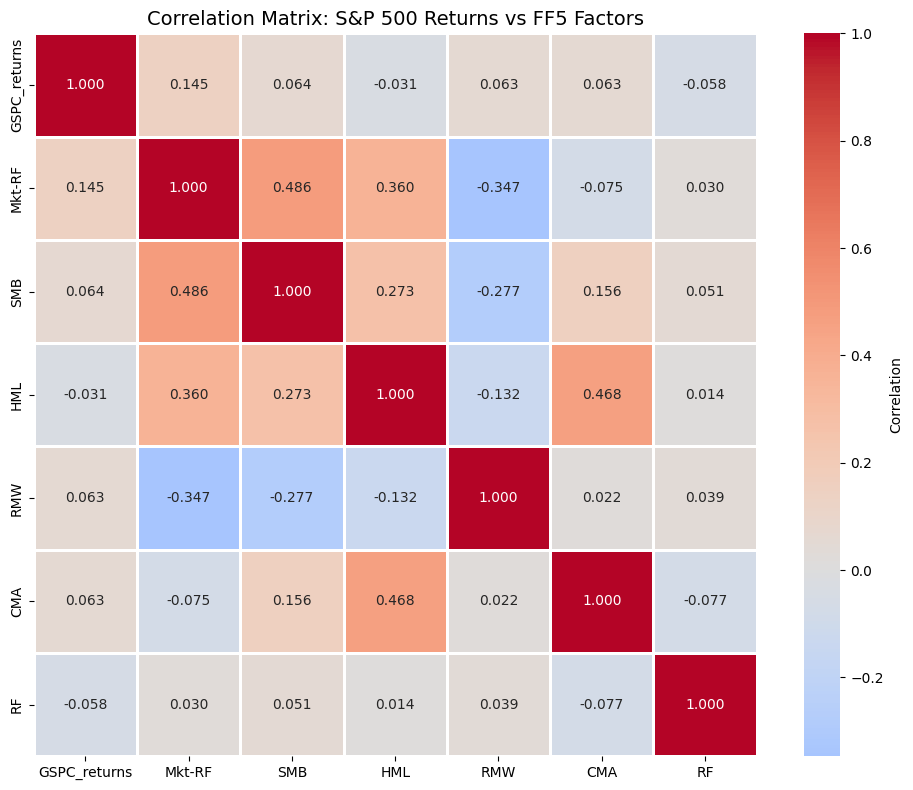


=== WHAT DOES THIS MEAN? ===
Strongest relationship: Mkt-RF (correlation = 0.145)
This factor moves most closely with S&P 500 returns

Weakest relationship: HML (correlation = -0.031)
This factor has little connection to S&P 500 returns

=== CORRELATION MATRIX INTERPRETATION ===
The heatmap shows how all variables relate to each other:
- Diagonal (1.0): Each variable perfectly correlates with itself
- Red colors: Positive correlation (move together)
- Blue colors: Negative correlation (move opposite)
- White/light colors: Weak or no correlation


In [12]:
# Combine GSPC returns with FF5 factors
combined = pd.DataFrame(gspc_returns)
combined.rename(columns={'^GSPC': 'GSPC_returns'}, inplace=True)
# combined = combined.join(ff5_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']], on='Date', how='left')

# Join on the datetime index (dates are already the index in both dataframes)
combined = combined.join(ff5_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']], how='left')



print("\n=== HOW RELATED ARE FACTORS TO S&P 500? ===")
print("Correlation ranges from -1 to +1:")
print("  +1 = Perfect positive relationship (move together)")
print("   0 = No relationship")
print("  -1 = Perfect negative relationship (move opposite)\n")

correlations = combined.corr()['GSPC_returns'].drop('GSPC_returns').sort_values(ascending=False)
print(correlations)

# Correlation heatmap (covariance matrix visualization)
plt.figure(figsize=(10, 8))
sns.heatmap(combined.corr(), annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: S&P 500 Returns vs FF5 Factors', fontsize=14)
plt.tight_layout()
plt.show()

# Simple interpretation
print("\n=== WHAT DOES THIS MEAN? ===")
strongest = correlations.abs().idxmax()
print(f"Strongest relationship: {strongest} (correlation = {correlations[strongest]:.3f})")
print(f"This factor moves most closely with S&P 500 returns")

weakest = correlations.abs().idxmin()
print(f"\nWeakest relationship: {weakest} (correlation = {correlations[weakest]:.3f})")
print(f"This factor has little connection to S&P 500 returns")

print("\n=== CORRELATION MATRIX INTERPRETATION ===")
print("The heatmap shows how all variables relate to each other:")
print("- Diagonal (1.0): Each variable perfectly correlates with itself")
print("- Red colors: Positive correlation (move together)")
print("- Blue colors: Negative correlation (move opposite)")
print("- White/light colors: Weak or no correlation")

##### Key Learnings from Correlation Analysis

##### 1. Mkt-RF (0.145) - Strongest Correlation 
**Why:** S&P 500 IS the market. They move together by definition.  
**Learning:** Market factor dominates S&P 500 returns.

##### 2. SMB (0.064) - Positive Correlation
**Why:** Small cap strength indicates healthy, broad-based economy.  
**Learning:** Small cap performance signals overall market health.

##### 3. HML (-0.031) - Negative Correlation
**Why:** S&P 500 is growth-heavy (Apple, Microsoft, etc.). When investors flee to "safe" value stocks, market struggles.  
**Learning:** Growth stocks drive S&P 500. Value outperformance = defensive market.

##### 4. RF (-0.058) - Negative Correlation
**Why:** High interest rates make bonds attractive → investors sell stocks. Low rates force money into stocks.  
**Learning:** Low rates = stocks thrive. High rates = stocks struggle. Fed policy matters!

##### 5. RMW (0.063) - Positive Correlation
**Why:** Profitable companies outperforming = healthy market fundamentals.  
**Learning:** Quality and profitability drive performance.

##### 6. CMA (0.063) - Positive Correlation
**Why:** Disciplined capital allocation (conservative investment) gets rewarded.  
**Learning:** Capital discipline correlates with market stability.

### Overall Story

**S&P 500 is driven by:**
- Overall market direction (Mkt-RF)
- Growth stock performance (tech-heavy index)
- Low interest rates (cheap money)
- Quality & profitability (fundamentals)
- Broad market health (small cap strength)

**S&P 500 struggles when:**
- Interest rates rise (Fed hiking)
- Investors flee to value/safety
- Speculation dominates (unprofitable companies lead)

**S&P 500 thrives when:**
- Interest rates are low (Fed accommodative)
- Growth stocks lead (tech boom)
- Strong fundamentals rewarded (quality rally)

#### Formal hypothesis test on correlation (Method #3)

- H₀ (null): true correlation between S&P 500 returns and Mkt-RF is 0.
- H₁ (alternative): true correlation is not 0.
- α = 0.05, Pearson correlation test.


In [13]:
# Hypothesis test: correlation between S&P 500 and Mkt-RF
valid = combined[['GSPC_returns', 'Mkt-RF']].dropna()

r, p_value = pearsonr(valid['GSPC_returns'], valid['Mkt-RF'])

print("=== PEARSON CORRELATION TEST: S&P 500 vs Mkt-RF ===")
print(f"Correlation coefficient (r): {r:.3f}")
print(f"p-value: {p_value:.4g}")


=== PEARSON CORRELATION TEST: S&P 500 vs Mkt-RF ===
Correlation coefficient (r): 0.145
p-value: 0.06622


**Hypothesis test result (Method #3):**

- Estimated correlation: **r ≈ 0.145**.
- p-value: **p ≈ 0.066**.

At the 5% significance level (α = 0.05), the p-value is slightly above the threshold, so we **do not reject H₀**. The sample shows a small positive correlation between S&P 500 monthly returns and the market factor (Mkt-RF), but it is only **marginally significant** (more in line with a 10%-level test than a 5%-level one).

In practice, economic theory and the Fama–French framework both treat **Mkt-RF** as the primary systematic risk factor, so we still include it as a key explanatory variable in our FF5 regression; this test simply tells us that, in this particular sample, the linear relationship with the S&P 500 index is modest rather than extremely strong.

